In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep

# Extracting Reviews from Trustpilot

This script scrapes customer reviews from Trustpilot for a given company or product. It collects various review details, including:

- Reviewer name
- Reviewer country
- Review title
- Review text
- Review date
- Rating
- Review link

## Functions

### `extract_reviews(page_url)`
- Extracts review data from a single Trustpilot page.
- Returns a list of dictionaries containing the review information.

### `extract_all_reviews(base_url, from_page=1, to_page=100)`
- Scrapes multiple pages of reviews starting from `from_page` to `to_page`.
- Aggregates the extracted reviews and returns them as a pandas DataFrame.

## Usage
- The `extract_all_reviews` function can be used with the base URL of a Trustpilot page to fetch reviews from multiple pages.
- Optionally, the resulting DataFrame can be saved to a CSV file.

> **Note**: The script is designed to work as of 06.04.2025. Updates may be required if Trustpilot changes its structure.


In [3]:
# Extract data from Trust Pilot, might need update due their site changing valid 06.04.2025

def extract_reviews(page_url):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    review_articles = soup.find_all('article', attrs={"data-service-review-card-paper": True})

    reviews_data = []
    for article in review_articles:
        review_text = article.find('p', attrs={"data-service-review-text-typography": True})
        review_text = review_text.get_text(strip=True) if review_text else None

        review_date_tag = article.find('time')
        review_date = review_date_tag.get_text(strip=True) if review_date_tag else None

        rating_tag = article.find('div', attrs={"data-service-review-rating": True})
        rating = rating_tag.get("data-service-review-rating") if rating_tag else None

        #New version of scraping
        reviewer_tag = article.find('span', attrs={"data-consumer-name-typography": True})
        reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else None
        #Country input
        country_tag = article.find('span', attrs={"data-consumer-country-typography": True})
        country = country_tag.get_text(strip=True) if country_tag else None



        title_tag = article.find('h2')
        review_title = title_tag.get_text(strip=True) if title_tag else None

        # Optional: review permalink
        link_tag = article.find('a', href=True)
        review_link = f"https://www.trustpilot.com{link_tag['href']}" if link_tag else None

        reviews_data.append({
            "Reviewer": reviewer_name,
            "Country": country,
            "Title": review_title,
            "Review Text": review_text,
            "Date": review_date,
            "Rating": rating,
            "Link": review_link
        })

    return reviews_data

def extract_all_reviews(base_url, from_page=1, to_page=100):
    all_reviews = []
    for page in range(from_page, to_page + 1):
        page_url = f"{base_url}?page={page}"
        print(f"Scraping: {page_url}")
        all_reviews.extend(extract_reviews(page_url))
        sleep(1)
    return pd.DataFrame(all_reviews)

# Example usage:
base_url = "https://www.trustpilot.com/review/www.coca-cola.com"
df_reviews = extract_all_reviews(base_url, from_page=1, to_page=100)

# Show the first few results
print(df_reviews.head())

# Optional: Save to CSV
df_reviews.to_csv("coca_cola_reviews_detailed.csv", index=False)


Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=1
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=2
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=3
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=4
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=5
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=6
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=7
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=8
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=9
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=10
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=11
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=12
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=13
Scraping: https://www.trustpilot.com/review/www.coca-cola.com?page=14
Scraping: https://www.trustpi

If all these 4 important features are missing - row will be dropped

In [4]:
df = pd.read_csv("coca_cola_reviews_detailed.csv")
# Drop rows where all values in the specified columns are NaN
df.dropna(subset=['Reviewer', 'Title', 'Review Text', 'Rating'], how='all', inplace=True)

In [5]:
#!python -m nltk.downloader all

# Sentiment Analysis on Reviews

This script performs sentiment analysis on the "Review Text" column of a DataFrame using the TextBlob library. It includes text preprocessing (lemmatization) to improve the analysis and extracts the polarity and subjectivity of each review.

## Functions

### `lemmatize_text(text)`
- Lemmatizes the words in the review text to ensure words like "ran" and "running" are treated as "run" for better consistency in sentiment analysis.

### `get_sentiment(text)`
- Analyzes the sentiment of the provided text using TextBlob.
- Returns:
  - `Polarity`: A value between -1 (negative) and 1 (positive), indicating the sentiment of the text.
  - `Subjectivity`: A value between 0 (objective) and 1 (subjective), indicating how subjective the text is.

## Steps
1. **Preprocessing**: Lemmatize review texts.
2. **Sentiment Analysis**: Calculate polarity and subjectivity for each review.
3. **Apply Sentiment Analysis**: Add sentiment columns (`Polarity` and `Subjectivity`) to the DataFrame.

## Notes
- The script assumes that the DataFrame `df` contains a column named "Review Text."
- It drops rows where the "Review Text" is not a string.


In [8]:
from textblob import TextBlob
import pandas as pd
#Lemmatize to make ran and running turn to run, to have better results

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if isinstance(text, str):  # Only process if the text is a string
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    else:
        return ''  # Return an empty string for non-string values


df['cleaned_review'] = df['Review Text'].apply(lemmatize_text)

# Assuming you have a DataFrame called df with 'Review Text' column

# Function to get the sentiment polarity
def get_sentiment(text):
    if text:  # Ensure text is not None or NaN
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity  # Sentiment polarity (-1 to 1)
        subjectivity = blob.sentiment.subjectivity  # Subjectivity (0 to 1)
        return polarity, subjectivity
    else:
        return None, None
    
# Drop rows where 'Review Text' is not a string
df = df[df['Review Text'].apply(lambda x: isinstance(x, str))]

# Apply sentiment analysis to each row
df[['Polarity', 'Subjectivity']] = df['cleaned_review'].apply(lambda x: pd.Series(get_sentiment(x)))

# Display the first few rows to see the results
df


,Reviewer,Country,Title,Review Text,Date,Rating,Link,cleaned_review,Polarity,Subjectivity
4,Dave,AU,Found a leaking can in my 30 can…,Found a leaking can in my 30 can purchase whic...,4 days ago,1.0,https://www.trustpilot.com/users/67ee290674626...,Found a leaking can in my 30 can purchase whic...,0.231818,0.441414
5,Jay,US,Free products for the IDF,I must have bought tens of thousands of diet C...,5 days ago,1.0,https://www.trustpilot.com/users/664a4863f9916...,I must have bought ten of thousand of diet Cok...,-0.040000,0.620000
6,Keneth Leonard,KE,Coca cola product is a great remedy for…,Coca cola product is a great remedy for cleani...,"Mar 30, 2025",1.0,https://www.trustpilot.com/users/67e94ec989ee1...,Coca cola product is a great remedy for cleani...,0.333333,0.316667
7,BeatZa BeatZa,CA,RACIST DIGUSTING HORRIBLE TERRIFYING :(,"Way back then coca cola was insainly racist , ...","Mar 24, 2025",1.0,https://www.trustpilot.com/users/67e16bec19dc1...,"Way back then coca cola wa insainly racist , t...",-0.258791,0.764286
8,Saheer Anas,IN,I felt Coco cola Sugar content is very…,"I felt Coco cola Sugar content is very high, a...","Mar 21, 2025",1.0,https://www.trustpilot.com/users/67dd8f48459f8...,"I felt Coco cola Sugar content is very high, a...",-0.567333,0.856222
...,...,...,...,...,...,...,...,...,...,...
1042,Ammie Opaline,BG,Perfect mineral water!,"I like their beverages very much, especially t...","Apr 21, 2016",5.0,https://www.trustpilot.com/users/5718b15e0000f...,"I like their beverage very much, especially th...",0.000000,1.000000
1043,riccardopari,IT,Excellent drink,i like Coca Cola but the website don't like3 s...,"Jan 6, 2016",3.0,https://www.trustpilot.com/users/568cee030000f...,i like Coca Cola but the website don't like3 star,0.000000,0.000000
1044,Kelly Ramsey,GB,Selling Deadly Poison To Children.,Cocacola steals water from people in poor part...,"Jul 25, 2014",1.0,https://www.trustpilot.com/users/53d1735900006...,Cocacola steal water from people in poor part ...,0.050000,0.666667
1045,Price Wright,US,I love coca-cola so much that I recently took ...,I have been in the beverage industry on and of...,"Jan 23, 2014",5.0,https://www.trustpilot.com/users/52e1ac6100006...,I have been in the beverage industry on and of...,0.483333,0.566667


# Word Frequency Analysis for Positive and Negative Reviews

This script analyzes the word frequency distribution for positive and negative reviews based on sentiment polarity using the `CountVectorizer` from Scikit-learn. It allows us to identify the most common words in reviews with different sentiments.

## Steps:
1. **Filter Reviews by Sentiment**:
   - Reviews with a `Polarity` greater than 0.5 are considered positive.
   - Reviews with a `Polarity` less than -0.5 are considered negative.

2. **Tokenization and Word Counting**:
   - For both positive and negative reviews, the `CountVectorizer` is used to tokenize the text and count the frequency of each word, excluding common stop words (e.g., "the", "and").

3. **Word Frequency Data**:
   - The word frequencies for both positive and negative reviews are calculated and converted into DataFrames for easy analysis.

4. **Top 10 Words**:
   - The script outputs the top 10 most frequent words in both positive and negative reviews.

## Output:
- **Top 10 Words in Positive Reviews**: A list of the most frequent words in reviews with a positive sentiment.
- **Top 10 Words in Negative Reviews**: A list of the most frequent words in reviews with a negative sentiment.

This helps in understanding the language used in different types of reviews and can be useful for deeper sentiment and trend analysis.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# List of words to exclude (e.g., common brand/product-related words)
custom_stop_words = ['cola', 'coke', 'drink', 'beverage', 'soda', 'coca', 'syrup', 'like', 'just', 'and']

# Assuming 'df' is the DataFrame with your reviews and sentiment scores
positive_reviews = df[df['Polarity'] > 0.5]['cleaned_review']  # Reviews with positive sentiment
negative_reviews = df[df['Polarity'] < -0.5]['cleaned_review']  # Reviews with negative sentiment

# Tokenize and count word frequency for positive reviews
vectorizer = CountVectorizer(stop_words='english', vocabulary=None)
positive_matrix = vectorizer.fit_transform(positive_reviews)

# Tokenize and count word frequency for negative reviews
negative_matrix = vectorizer.transform(negative_reviews)

# Convert matrix to DataFrame for easier analysis
positive_freq = pd.DataFrame(positive_matrix.toarray(), columns=vectorizer.get_feature_names_out())
negative_freq = pd.DataFrame(negative_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Sum up the frequency of each word in positive and negative reviews
positive_word_count = positive_freq.sum().sort_values(ascending=False)
negative_word_count = negative_freq.sum().sort_values(ascending=False)

# Remove unwanted words from the counts (if they are present in the word list)
positive_word_count = positive_word_count[~positive_word_count.index.isin(custom_stop_words)]
negative_word_count = negative_word_count[~negative_word_count.index.isin(custom_stop_words)]

# Show top 10 words
print("Top 10 words in Positive Reviews:")
print(positive_word_count.head(10))

print("\nTop 10 words in Negative Reviews:")
print(negative_word_count.head(10))


Top 10 words in Positive Reviews:
good        30
best        20
love        18
taste       12
great        9
company      7
pepsi        7
product      6
ha           5
drinking     5
dtype: int64

Top 10 words in Negative Reviews:
company       19
product       11
taste          7
don            6
support        5
sponsor        5
corruption     4
pepsi          4
make           4
care           3
dtype: int64


### Word Frequency Analysis: Positive and Negative Reviews

In our analysis of word frequencies across both positive and negative reviews, we excluded certain terms that are more generic or related to the product itself, such as "cola", "coke", "product", and "company". These words are used frequently in both contexts but don't contribute significant sentiment information, so we opted to remove them from the analysis.

#### Top 10 Words in Positive Reviews:
- **good (30)**: A common indicator of positive sentiment, reflecting the favorable reception of the product.
- **best (20)**: Suggests a highly positive sentiment, indicating that the product is regarded as superior.
- **love (18)**: Expresses strong positive affection or admiration.
- **taste (12)**: A key aspect in reviews, reflecting how users feel about the flavor.
- **great (9)**: Another term strongly linked to positive feedback.
- **company (7)**: Mentioned due to association with the brand but neutral in sentiment.
- **pepsi (7)**: Commonly referenced as the brand in reviews, though neutral by itself.
- **product (6)**: Used to refer to the item being reviewed, without specific sentiment attached.
- **ha (5)**: A common expression, sometimes used in a lighthearted or humorous way.
- **drinking (5)**: Refers to the act of consuming the product, generally positive when mentioned in a context of enjoyment.

#### Top 10 Words in Negative Reviews:
- **company (19)**: Often used negatively when reviewers complain about customer service or corporate policies.
- **product (11)**: While neutral by itself, it can be associated with dissatisfaction when the review is negative.
- **taste (7)**: When mentioned negatively, it likely refers to dissatisfaction with the flavor.
- **don (6)**: Commonly used in complaints, likely part of expressions like "don't like".
- **support (5)**: Reflects frustration with customer service or lack of adequate assistance.
- **sponsor (5)**: Could relate to negative sentiments about sponsorship or partnerships.
- **corruption (4)**: A strong negative term, indicating dissatisfaction with unethical practices.
- **pepsi (4)**: While the brand is mentioned, it typically carries negative connotations in these reviews as being superior to coke.
- **make (4)**: Often part of expressions of dissatisfaction, such as "doesn't make sense" or "didn't make it".
- **care (3)**: Reflects complaints about poor attention or lack of care in service or quality.

### Conclusion:
This word frequency analysis provides a clear picture of the language used in both positive and negative reviews. Positive reviews often focus on terms associated with enjoyment, like "good", "love", and "best". Negative reviews, however, tend to include more critical terms such as "company", "support", and "


In [14]:
correlation = df[['Polarity', 'Rating']].corr()

# Display the correlation matrix
print(correlation)

          Polarity    Rating
Polarity  1.000000  0.540263
Rating    0.540263  1.000000


While there is a positive correlation between sentiment polarity and ratings, this correlation is not perfect. This suggests that while positive reviews tend to have higher ratings, there are additional factors at play that may influence the overall rating, beyond just the sentiment expressed in the text.


In [9]:
#!pip install accelerate 
#if there is a problem like NameError: name 'init_empty_weights' is not defined, hope it helps

### Text Generation using GPT-2 Model

This script demonstrates how to use the GPT-2 model from Hugging Face's Transformers library to generate text based on a given input prompt. Below is an explanation of each part of the code:

1. **Model and Tokenizer Initialization:**
   - The script loads a pre-trained GPT-2 model and its corresponding tokenizer. This allows us to generate text using GPT-2.
   - You can adjust the `model_name` to use different models like `gpt-neo` or `gpt-j` for alternative architectures.

2. **Input Text (Prompt):**
   - The variable `input_text` is set to `"Once upon a time"`, which serves as the starting point for text generation.
   - This prompt is what the model will expand upon when generating text.

3. **Tokenization:**
   - The `tokenizer.encode()` function converts the input text into a sequence of numerical tokens that the model can process.
   - The `return_tensors="pt"` argument ensures the tokens are returned as PyTorch tensors.

4. **Text Generation:**
   - The `model.generate()` function is called to generate the text. Here, `max_length=100` limits the output to 100 tokens, and `num_return_sequences=1` indicates that only one sequence will be generated.

5. **Decoding and Output:**
   - The `tokenizer.decode()` method converts the generated tokens back into human-readable text.
   - The resulting text is printed as the output, showcasing the model's generated content.


In [15]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the model and tokenizer
model_name = 'gpt2'  # You can change this to another model like 'gpt-neo', 'gpt-j', etc.
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Encode the input text (prompt)
input_text = "Once upon a time"
inputs = tokenizer.encode(input_text, return_tensors="pt")

# Generate text using the model
outputs = model.generate(inputs, max_length=100, num_return_sequences=1)

# Decode and print the output text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated text:", generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text: Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great


Example of how it works

In [16]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis")

# Define your review text (or input text)
review_text = "I absolutely love this product! It's amazing and works perfectly."

# Perform sentiment analysis
result = sentiment_analysis(review_text)

# Print the result
print(f"Sentiment: {result[0]['label']}, with a score of {result[0]['score']:.4f}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Sentiment: POSITIVE, with a score of 0.9999


C:\Users\mrazi\anaconda3\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:401: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


### Sentiment Analysis in Batches

This script performs sentiment analysis on a set of reviews, utilizing batch processing to speed up the process, especially useful for large datasets. Below is an explanation of the code:

1. **Prepare Data for Sentiment Analysis:**
   - The `df['Review Text']` column is converted into a list using `.tolist()`, which is easier to pass to the sentiment analysis function.

2. **Batch Processing for Speed:**
   - The `sentiment_analysis()` function is called on the list of reviews. 
   - The `truncation=True` argument ensures that any reviews that are too long are truncated, avoiding errors during processing.
   - The `batch_size=32` allows the model to process reviews in batches, improving the speed and efficiency of the analysis, particularly when dealing with a large number of reviews. You can adjust the batch size depending on system resources.

3. **Adding Sentiment Analysis Results to DataFrame:**
   - The sentiment analysis results are stored in the `results` variable, which is a list of dictionaries containing the sentiment label and the score for each review.
   - The sentiment label (e.g., 'POSITIVE' or 'NEGATIVE') is extracted from the `results` and added to a new column `df['sentiment']`.
   - The sentiment score (a numerical value representing the confidence in the prediction) is also extracted and added to a new column `df['score']`.

4. **Resulting DataFrame:**
   - The DataFrame `df` is updated with the sentiment and score information, allowing further analysis or visualization.


In [17]:
# Analyze in batches (optional for speed)
reviews = df['Review Text'].tolist()
results = sentiment_analysis(reviews, truncation=True, batch_size=32)  # adjust batch size if needed

# Add results to DataFrame
df['sentiment'] = [r['label'] for r in results]
df['score'] = [r['score'] for r in results]
df

,Reviewer,Country,Title,Review Text,Date,Rating,Link,cleaned_review,Polarity,Subjectivity,sentiment,score
4,Dave,AU,Found a leaking can in my 30 can…,Found a leaking can in my 30 can purchase whic...,4 days ago,1.0,https://www.trustpilot.com/users/67ee290674626...,Found a leaking can in my 30 can purchase whic...,0.231818,0.441414,NEGATIVE,0.998214
5,Jay,US,Free products for the IDF,I must have bought tens of thousands of diet C...,5 days ago,1.0,https://www.trustpilot.com/users/664a4863f9916...,I must have bought ten of thousand of diet Cok...,-0.040000,0.620000,NEGATIVE,0.999638
6,Keneth Leonard,KE,Coca cola product is a great remedy for…,Coca cola product is a great remedy for cleani...,"Mar 30, 2025",1.0,https://www.trustpilot.com/users/67e94ec989ee1...,Coca cola product is a great remedy for cleani...,0.333333,0.316667,POSITIVE,0.953303
7,BeatZa BeatZa,CA,RACIST DIGUSTING HORRIBLE TERRIFYING :(,"Way back then coca cola was insainly racist , ...","Mar 24, 2025",1.0,https://www.trustpilot.com/users/67e16bec19dc1...,"Way back then coca cola wa insainly racist , t...",-0.258791,0.764286,NEGATIVE,0.996086
8,Saheer Anas,IN,I felt Coco cola Sugar content is very…,"I felt Coco cola Sugar content is very high, a...","Mar 21, 2025",1.0,https://www.trustpilot.com/users/67dd8f48459f8...,"I felt Coco cola Sugar content is very high, a...",-0.567333,0.856222,NEGATIVE,0.999809
...,...,...,...,...,...,...,...,...,...,...,...,...
1042,Ammie Opaline,BG,Perfect mineral water!,"I like their beverages very much, especially t...","Apr 21, 2016",5.0,https://www.trustpilot.com/users/5718b15e0000f...,"I like their beverage very much, especially th...",0.000000,1.000000,POSITIVE,0.999745
1043,riccardopari,IT,Excellent drink,i like Coca Cola but the website don't like3 s...,"Jan 6, 2016",3.0,https://www.trustpilot.com/users/568cee030000f...,i like Coca Cola but the website don't like3 star,0.000000,0.000000,NEGATIVE,0.988362
1044,Kelly Ramsey,GB,Selling Deadly Poison To Children.,Cocacola steals water from people in poor part...,"Jul 25, 2014",1.0,https://www.trustpilot.com/users/53d1735900006...,Cocacola steal water from people in poor part ...,0.050000,0.666667,POSITIVE,0.551423
1045,Price Wright,US,I love coca-cola so much that I recently took ...,I have been in the beverage industry on and of...,"Jan 23, 2014",5.0,https://www.trustpilot.com/users/52e1ac6100006...,I have been in the beverage industry on and of...,0.483333,0.566667,POSITIVE,0.999867


Correlation is showing that there is almost no connection between rating and score
Reason is that score in both positive and negative results has positive numbers

In [18]:
correlation = df[['score', 'Rating']].corr()

# Display the correlation matrix
# Display that correlation doesn't work cause both NEGATIVE AND POSITIVE SCORES HAVE THE SAME SIGNS
print(correlation)

           score    Rating
score   1.000000  0.028062
Rating  0.028062  1.000000


Making correction

In [19]:
df.loc[df["sentiment"] == "NEGATIVE", "score"] *= -1

Score is stil not high, but 65% is decent regarding customers
that tend to put 4 if they don't like something but still loyal
or despite having good experience putting 3

In [20]:
correlation = df[['score', 'Rating']].corr()

# Display the correlation matrix with better results
print(correlation)

           score    Rating
score   1.000000  0.657475
Rating  0.657475  1.000000


## Word Frequency Analysis in Positive and Negative Reviews

This script performs word frequency analysis on reviews classified as positive and negative. It processes the reviews by tokenizing the text and counting the most common words. Here's an explanation of the steps:

1. **Text Cleaning and Tokenization:**
   - The `tokenize()` function is used to clean and tokenize the reviews:
     - Converts the text to lowercase to ensure uniformity.
     - Removes non-alphabetic characters and short words (less than 3 characters).
     - Filters out common stopwords like "the", "is", etc., to focus on more meaningful words.

2. **Combining Reviews:**
   - The positive and negative reviews are extracted from the DataFrame `df` and combined into two large strings (`positive_text` and `negative_text`) for analysis.

3. **Tokenizing the Combined Text:**
   - The reviews are tokenized using the `tokenize()` function, resulting in lists of words for both positive and negative reviews (`positive_words` and `negative_words`).

4. **Counting Word Frequencies:**
   - The `Counter()` class from the `collections` module is used to count the frequency of each word in both positive and negative reviews.
   - The most common 10 words in each category are extracted using the `most_common(10)` method.

5. **Displaying Results:**
   - The script prints the top 10 most frequent words for both positive and negative reviews, allowing us to see the most common words associated with each sentiment.


In [24]:
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add custom words to be excluded
custom_stopwords = {"cola", "coca", "coke"}
stop_words.update(custom_stopwords)

# Helper function to clean and tokenize text
def tokenize(text):
    # Lowercase and remove non-alphabetic characters
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())  # only words with 3+ letters
    return [word for word in words if word not in stop_words]

# Combine all positive and negative reviews into one big text
positive_text = " ".join(df[df["sentiment"] == "POSITIVE"]["Review Text"])
negative_text = " ".join(df[df["sentiment"] == "NEGATIVE"]["Review Text"])

# Tokenize and count word frequencies
positive_words = tokenize(positive_text)
negative_words = tokenize(negative_text)

positive_top10 = Counter(positive_words).most_common(10)
negative_top10 = Counter(negative_words).most_common(10)

# Display results
print("Top 10 Words in Positive Reviews:")
for word, count in positive_top10:
    print(f"{word}: {count}")

print("\nTop 10 Words in Negative Reviews:")
for word, count in negative_top10:
    print(f"{word}: {count}")


Top 10 Words in Positive Reviews:
drink: 68
good: 46
love: 43
best: 34
like: 31
company: 30
pepsi: 28
white: 28
taste: 26
one: 21

Top 10 Words in Negative Reviews:
league: 141
company: 138
premier: 138
drink: 111
corrupt: 111
pepsi: 105
like: 91
products: 88
white: 85
taste: 77


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrazi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Analysis of Top Words

Although words alone may not provide a complete picture, we can already see some interesting patterns. For instance, the words **"corrupt"**, **"pepsi"**, and **"premier"** in the negative reviews hint at some common complaints regarding the brand's involvement in controversies or issues with the product. In the positive reviews, terms like **"good"**, **"love"**, **"best"**, and **"pepsi"** suggest a generally favorable view of the product, highlighting positive experiences with the brand.

However, to make these insights clearer and more actionable, we will explore the most frequently used **bigrams** (two-word combinations) in the reviews. This will allow us to uncover deeper insights and


In [25]:
# Just words might lead to some understanding but it would be better to have more understanding by combining them

from sklearn.feature_extraction.text import CountVectorizer

# Only for positive reviews
positive_reviews = df[df['sentiment'] == 'POSITIVE']['Review Text'].tolist()
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(positive_reviews)
pos_ngrams = vectorizer.get_feature_names_out()

print("Top Positive Bigrams:", pos_ngrams)


Top Positive Bigrams: ['best drink' 'best soda' 'coca cola' 'coke zero' 'cola best'
 'cola products' 'diet coke' 'don care' 'drink coca' 'drink world'
 'english premier' 'love coca' 'love drink' 'love love' 'number times'
 'premier league' 'really enjoy' 'soft drink' 'soft drinks' 'times use']


In [26]:
# Only for negative reviews
positive_reviews = df[df['sentiment'] == 'NEGATIVE']['Review Text'].tolist()
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(positive_reviews)
pos_ngrams = vectorizer.get_feature_names_out()

print("Top Negative Bigrams:", pos_ngrams)


Top Negative Bigrams: ['buy coke' 'coca cola' 'coke cola' 'coke products' 'coke zero'
 'cola company' 'cola products' 'corrupt organisation' 'corrupt premier'
 'customer service' 'english premier' 'like coca' 'newcastle united'
 'premier league' 'racist company' 'sponsor corrupt' 'sponsoring corrupt'
 'sponsors corrupt' 'stay politics' 'white people']


### Analysis of Top Bigrams

Upon examining the most frequently used bigrams, we can gain more context about the sentiments behind the reviews:

#### Top Positive Bigrams:
- **"best drink"**, **"best soda"**, **"coca cola"**, and **"coke zero"** highlight customers' appreciation for specific drinks, with many associating Coca-Cola and Coke Zero with being among the best options available.
- **"cola best"** and **"cola products"** indicate strong positive sentiment towards Coca-Cola's range of products.
- **"love coca"**, **"love drink"**, and **"love love"** further emphasize the emotional connection customers have with the brand.
- **"really enjoy"**, **"soft drink"**, and **"soft drinks"** reflect satisfaction with the product in general, pointing to overall enjoyment.

#### Top Negative Bigrams:
- **"buy coke"**, **"coca cola"**, **"coke cola"**, and **"coke products"** appear frequently, indicating a strong association with negative experiences related to these products.
- **"corrupt organisation"**, **"corrupt premier"**, **"racist company"**, **"sponsor corrupt"**, and **"sponsoring corrupt"** suggest a significant negative sentiment tied to accusations of corruption and problematic corporate behavior.
- **"customer service"** and **"cola company"** point to dissatisfaction with the company’s service and product quality.
- **"newcastle united"** and **"premier league"** further highlight the association of negative experiences with sports sponsorships.
- **"stay politics"** and **"white people"** suggest that political and social issues might also be factors influencing negative opinions about the brand.

The bigrams give us a clearer picture of what drives positive and negative sentiment towards Coca-Cola, with product quality and customer experience playing a central role in both reviews. The negative bigrams also reveal strong sentiments related to social and political concerns.


In [27]:
# Only for negative reviews
negative_reviews = df[df['sentiment'] == 'NEGATIVE']['Review Text'].tolist()

# Create the trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=20)

# Fit the vectorizer on the negative reviews
X = vectorizer.fit_transform(negative_reviews)

# Get the top negative trigrams
neg_ngrams = vectorizer.get_feature_names_out()

print("Top Negative Trigrams:", neg_ngrams)


Top Negative Trigrams: ['buy coca cola' 'coca cola company' 'coca cola product'
 'coca cola products' 'coca cola zero' 'corrupt organisation premier'
 'corrupt premier league' 'corruption premier league' 'drink coca cola'
 'english premier league' 'like coca cola' 'like premier league'
 'organisation premier league' 'premier league corruption'
 'sponsor corrupt premier' 'sponsor premier league'
 'sponsoring corrupt organisation' 'sponsoring corrupt premier'
 'sponsors corrupt organisation' 'sponsors corrupt premier']


In [28]:
# Only for positive reviews
positive_reviews = df[df['sentiment'] == 'POSITIVE']['Review Text'].tolist()

# Create the trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=20)

# Fit the vectorizer on the negative reviews
X = vectorizer.fit_transform(positive_reviews)

# Get the top negative trigrams
pos_ngrams = vectorizer.get_feature_names_out()

print("Top Positive Trigrams:", pos_ngrams)

Top Positive Trigrams: ['believe coca cola' 'best drink world' 'buy coca cola' 'coca cola best'
 'coca cola products' 'coca cola tastes' 'coca cola wanted'
 'coca cola zero' 'cola best drink' 'company does good' 'drink coca cola'
 'drink way catch' 'drinking coca cola' 'english premier league'
 'fastest drink way' 'happy jump bed' 'leading brand happy'
 'love coca cola' 'marketing thing company' 'premier league pepsi']


Trigrams don't give much more insight than bigrams but still might be worth to use

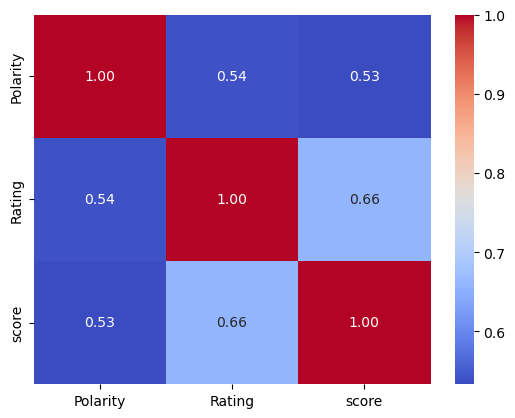

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['Polarity', 'Rating', 'score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


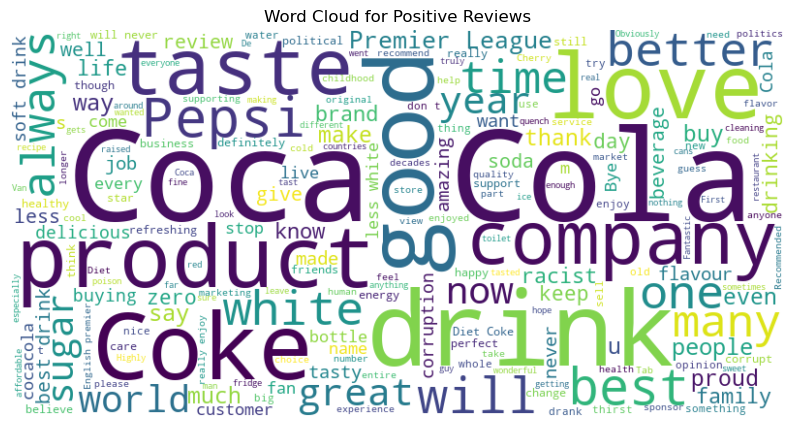

In [30]:
#!pip install wordcloud
from wordcloud import WordCloud

# Generate WordCloud for Positive Reviews
positive_text = " ".join(df[df['sentiment'] == 'POSITIVE']['Review Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Positive Reviews")
plt.axis("off")
plt.show()


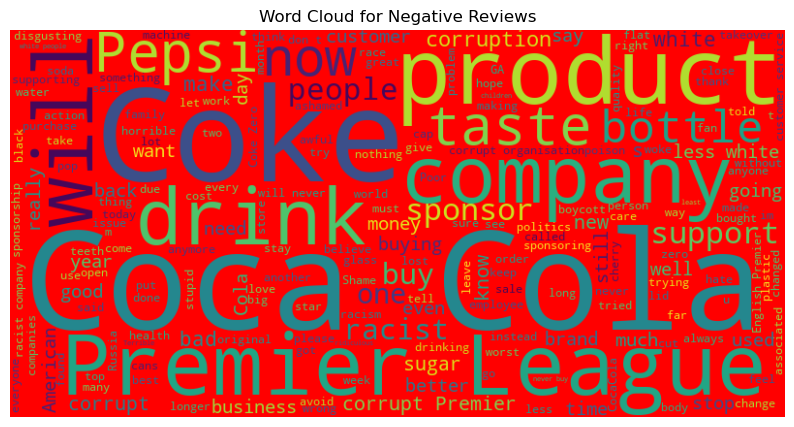

In [31]:
# Generate WordCloud for Positive Reviews
negative_text = " ".join(df[df['sentiment'] == 'NEGATIVE']['Review Text'])
wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Negative Reviews")
plt.axis("off")
plt.show()

### Conclusion

The comprehensive analysis of Coca-Cola's Trustpilot reviews has provided a detailed understanding of consumer sentiment and key factors influencing brand perception. By extracting and processing the reviews, we were able to uncover patterns and trends related to customer satisfaction and dissatisfaction, categorizing sentiment into positive and negative groups.

Positive reviews predominantly reflect high satisfaction with the product quality, with a strong emphasis on terms like "best drink," "love," and "taste," which highlight consumers' favorable views of Coca-Cola’s offerings. The positive sentiment is often tied to specific product lines, such as "Coca-Cola" and "Coke Zero," indicating strong brand loyalty and satisfaction within those categories.

In contrast, negative reviews reveal concerns that primarily center around corporate ethics, customer service, and perceived political involvement. Words such as "corrupt," "racist," and "customer service" dominate the negative reviews, suggesting that while the product itself may be enjoyed by many, issues related to the company's business practices and public relations efforts have generated significant customer dissatisfaction. The strong presence of terms like "premier league" and "sponsorship" further underscores the controversy surrounding Coca-Cola’s involvement in high-profile partnerships and the potential disconnect between its corporate actions and consumer expectations.

The bigram analysis further helped to contextualize the reviews by revealing associations between product names and corporate criticisms. For instance, the recurring pairing of "Coca-Cola" and "corrupt organization" reflects public backlash tied to corporate decisions rather than product quality itself.

This analysis provides valuable insights for Coca-Cola’s marketing and customer service teams. To improve its brand image and foster deeper consumer loyalty, the company could benefit from addressing concerns related to corporate governance, sponsorship decisions, and customer service. By aligning its product excellence with transparency and corporate responsibility, Coca-Cola can ensure sustained positive sentiment while mitigating potential reputational risks.
